In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def normalize_data(data, minimum=0, maximum=1):
    data_min = np.min(data)
    data_max = np.max(data)
    return minimum + ((data - data_min) / (data_max - data_min)) * (maximum - minimum)

In [5]:
X = normalize_data(np.random.randn(200, 244, 244, 1), minimum=0, maximum=1) # 5 images of 28x28 and 1 channel

In [6]:
K_size = (3, 3)
input_channels = 1
num_filters = 4
padding = 1
stride = 1

In [7]:
Wconv = np.random.randn(K_size[0], K_size[1], input_channels, num_filters) * 0.1
bconv = np.zeros((1, num_filters))

In [8]:
def forward_convolution(x, W, b, padding=1, stride=1):
    m, H_in, W_in, _ = x.shape
    f_h, f_w, _, num_filters = W.shape

    H_out = (H_in + 2 * padding - f_h) // stride + 1
    W_out = (W_in + 2 * padding - f_w) // stride + 1
    
    x_padded = np.pad(x, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')
    outputs = np.zeros((m, H_out, W_out, num_filters))

    for i in range(m):
        for h in range(H_out):
            h_start = h * stride
            h_end = h_start + f_h
            
            for w in range(W_out):
                w_start = w * stride
                w_end = w_start + f_w

                x_slice = x_padded[i, h_start:h_end, w_start:w_end, :]
                for f in range(num_filters):
                    conv = np.sum(x_slice * W[..., f])
                    conv += b[0, f]
                    outputs[i, h, w, f] = conv

    return outputs

In [9]:
images_conv = forward_convolution(x=X, W=Wconv, b=bconv, padding=padding, stride=stride)
print(images_conv.shape)

(200, 244, 244, 4)


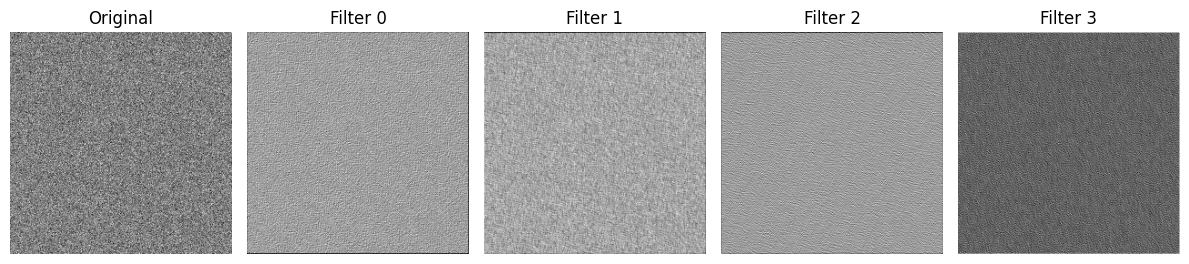

In [10]:
plt.figure(figsize=(12, 3))

plt.subplot(1, num_filters + 1, 1)
plt.imshow(X[0, :, :, 0], cmap='gray')
plt.title("Original")
plt.axis('off')

for f in range(num_filters):
    plt.subplot(1, num_filters + 1, f + 2)
    plt.imshow(images_conv[0, :, :, f], cmap='gray')
    plt.title(f"Filter {f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
def backward_convolution(x, deltas, W, b, padding=1, stride=1):
    m, H_in, W_in, C = x.shape
    f_h, f_w, _, num_filters = W.shape

    H_out = (H_in + 2 * padding - f_h) // stride + 1
    W_out = (W_in + 2 * padding - f_w) // stride + 1

    dW = np.zeros_like(W)
    db = np.zeros_like(b)

    dx_padded = np.pad(x, ((0, 0), (padding, padding), (padding, padding), (0, 0)), mode='constant')

    for i in range(m):
        for h in range(H_out):
            h_start = h * stride
            h_end = h_start + f_h
            
            for w in range(W_out):
                w_start = w * stride
                w_end = w_start + f_w

                for f in range(num_filters):
                    x_slice = dx_padded[i, h_start:h_end, w_start:w_end, :]

                    dW[..., f] += x_slice * deltas[i, h, w, f]

                    dx_padded[i, h_start:h_end, w_start:w_end, :] += W[..., f] * deltas[i, h, w, f]

                    db[0, f] += deltas[i, h, w, f]

    dW /= m
    db /= m

    if padding > 0:
        dx = dx_padded[:, padding:-padding, padding:-padding, :]
    else:
        dx = dx_padded

    return dx, dW, db


In [12]:
deltas = np.random.randn(*images_conv.shape)

In [13]:
dx, dW, db = backward_convolution(x=X, deltas=deltas, W=Wconv, b=bconv, padding=padding, stride=stride)
print("dx shape:", dx.shape)
print("dW shape:", dW.shape)
print("db shape:", db.shape)

dx shape: (200, 244, 244, 1)
dW shape: (3, 3, 1, 4)
db shape: (1, 4)
